## ABM prototype

Check that the working directory is within the main 'mhm/' folder, otherwise change it.

In [1]:
import os
WORK_DIR = os.getcwd()
correct_folder = '/Users/evaviviani/github/mhm'

if WORK_DIR == correct_folder:
    print('you are already in the correct folder')
elif WORK_DIR != correct_folder:
    os.chdir(correct_folder)
    print('you are NOW in the correct folder')

you are NOW in the correct folder


In [2]:
from mhm.agent import Population
import mhm.utils as ut
import numpy as np
import pandas as pd
import random

## How agents work

Agents have three characteristics:

1. **features**, immutable variables (e.g., gender, age, etc)
2. **states**, mutable variables (e.g., employed, infected, mental health and number of contacts)
3. **actions**, functions which change the agents' status (e.g., go to work, socialise)

## How a simulation works

Every day an agent can choose an action (ideally multiple actions a day). The simulation will start from day = 0 up until max(steps). At every step, it will check the type of agents' features -> states and thus choices and will apply some lockdown policies. These policies will affect the agents' availability of actions and therefore their states.

We will collect the output of those states as a dataframe every step, i.e., every day.

### Generate a population with given paramenters

We build a population of n agents with the following parameters:

In [3]:
parameters = {'n' : 50,
              'n_age_groups':4,
              'min_age':24,
              'max_age': 65,
              'age_strata': [.25, .23, .31, .21],
              'low_education': .11,
              'medium_education': .25,
              'high_education': .64,
              'employed_true': .76,
              'employed_false_seeking': .155,
              'employed_false_other': .085,
              'single': .20,
              'married': .31,
              'live_in_partner': .25,
              'in_relationship_no_cohabitation': .19,
              'other_relationship': .04,
              '%_gender':50,
              '%_depression': 20,
              '%_addiction': 5,
              '%_fatigue': 5,
              '%_burnout': 73,
              '%_child': 7,
              '%_child_inhouse': 58,
              '%_single_parent': 5,
              'finance_difficulties_false': 75,
              'finance_difficulties_many': 12,
              'finance_difficulties_some': 13,
              'health_difficulties_false': 65,
              'health_difficulties_many': 14,
              'health_difficulties_some': 20,
              'housing_difficulties_false': 79,
              'housing_difficulties_many': 3,
              'housing_difficulties_some': 18,
              'partner_difficulties_false': 67,
              'partner_difficulties_many': 5,
              'partner_difficulties_some': 18,
              'partner_difficulties_other': 10,
              'white_collar': 20,
              'medical_professional': 20,
              'key_worker': 20,
              'other_job': 40,
              'urban': 70,
              'rural': 30,
              'low_ses': 15,
              'medium_ses': 55,
              'high_ses': 30
}

In [4]:
people = Population(parameters=parameters)

Plot agents' characteristics at the population level

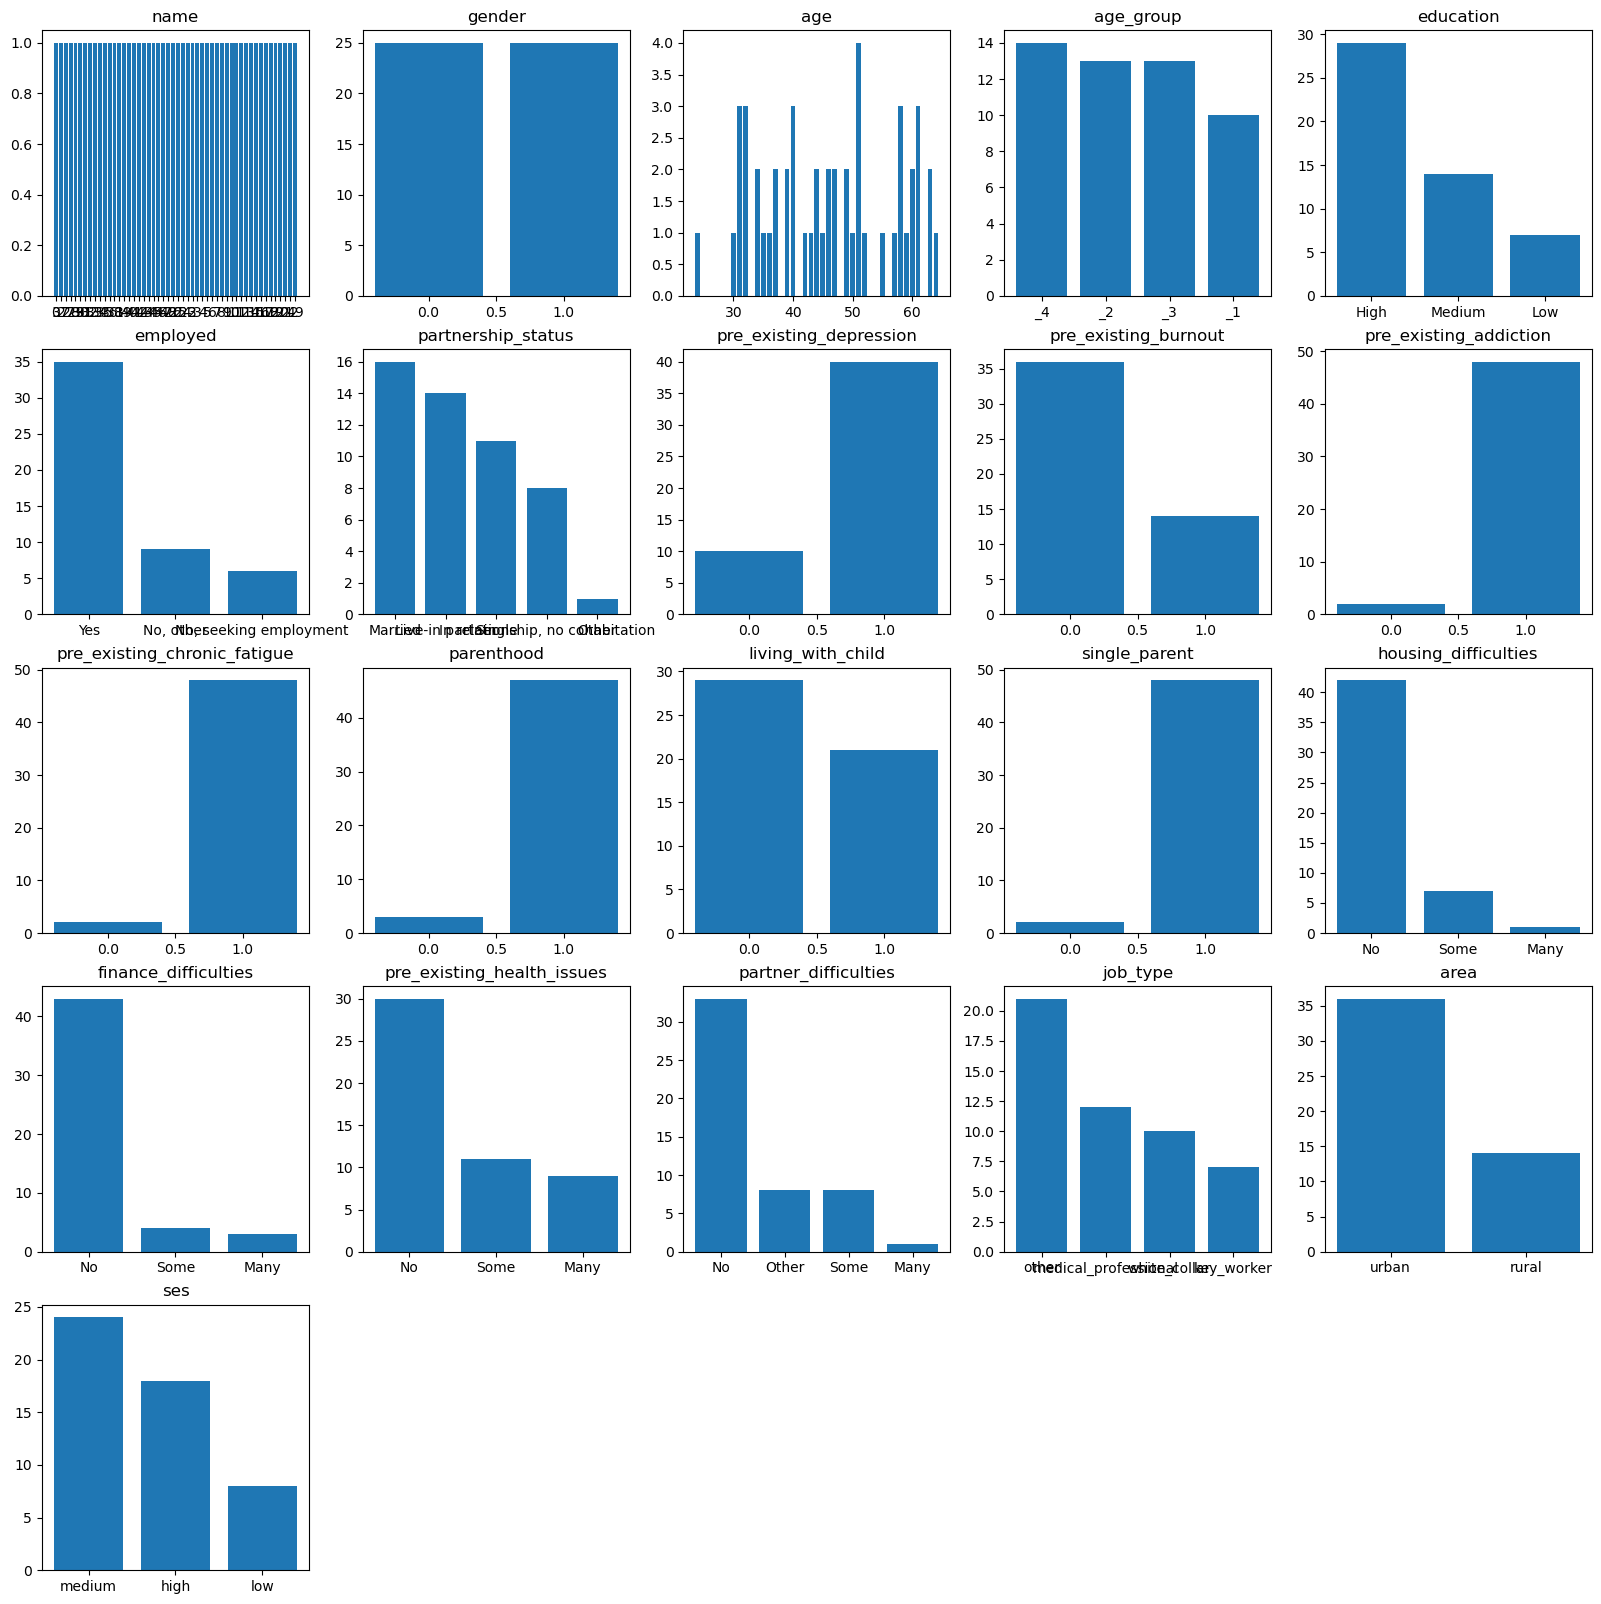

In [5]:
people.plot_summary()

We simulate a world made of agents, who can choose to make actions every day. The actions, in interaction with the agents' features, have a modulating effect on two dependent variables: number of contacts, and mental health. Actions available to the agents are dictated by the world's lockdown state which can limit the type of actions.

These are the actions that are available to agents:

- **go_to_work** = This action includes any work-related activity outside of the home, i.e., go work at the hospital, at school, at a construction site.
- **maintain_physical_distance** = This action includes any guidance on mantaining a safe space from others, i.e., mantaining 1.5m distance, do not shake hands, host no more than X people at home.
- **stay_at_home** = This action includes guidance on working from home and quarantining.
- **exercise** = This action includes guidance on sport activities allowed, i.e., taking a walk in the park, going to the gym, walking your dog or doing yoga
- **socialise** = This includes all social activities to do together with at least another agent, i.e., going to the cinema, to cafes, to museums, etc
- **travel** = This includes taking a train, a bus, a plane or driving the car
- **seek_help** = This includes seeking help in case an agent feels his mental health deteriorating, i.e., from a mental health professional or calling a helpline
- **negative_coping** = This relates negative coping strategies, such as smoking more tabacco, using drugs, drinking alcohol, losing faith in the government
- **positive_coping** = This relates positive coping strategies, such as learn new skills, keep contacts with distant relatives online, keeping a diary or playing indoor games.

We can have three types of lockdowns: easy, medium and hard. We also have a no-lockdown policy. Each one of those policies will affect the probability that each action get chosen by the agents.


I'm goint to try to build this system now. First lets convert our agents' categorical variables into numerical variables. We do that via one-hot encoding.

In [6]:
features_df = ut.make_features_dataframe(people.population)

In [7]:
display(features_df.head())

,name,gender,age,age_group,education,employed,partnership_status,pre_existing_depression,pre_existing_burnout,pre_existing_addiction,...,parenthood,living_with_child,single_parent,housing_difficulties,finance_difficulties,pre_existing_health_issues,partner_difficulties,job_type,area,ses
0,0,1,34,_1,Medium,"No, other",Live-in partner,1,0,1,...,1,0,1,No,No,No,Other,other,rural,low
1,1,0,36,_2,High,Yes,Live-in partner,1,0,1,...,1,0,1,No,No,Some,No,white_collar,urban,low
2,2,0,40,_2,High,"No, other",Live-in partner,1,1,1,...,1,1,1,No,No,Some,No,white_collar,rural,medium
3,3,1,42,_2,High,Yes,Married,0,0,1,...,1,0,1,Many,No,Some,No,medical_professional,urban,medium
4,4,1,49,_3,High,Yes,Live-in partner,1,0,1,...,1,1,1,No,No,Many,Some,key_worker,urban,medium


In [8]:
categorical_variables = ['age_group', 'education', 'employed', 
                         'partnership_status', 'housing_difficulties', 'finance_difficulties',
                         'pre_existing_health_issues', 'partner_difficulties', 'job_type', 'area', 'ses']
encoded_features = ut.one_hot_encoding(features_df, cols = categorical_variables)
display(encoded_features.head())

,name,gender,age,pre_existing_depression,pre_existing_burnout,pre_existing_addiction,pre_existing_chronic_fatigue,parenthood,living_with_child,single_parent,...,partner_difficulties_Some,job_type_key_worker,job_type_medical_professional,job_type_other,job_type_white_collar,area_rural,area_urban,ses_high,ses_low,ses_medium
0,0,1,34,1,0,1,1,1,0,1,...,0,0,0,1,0,1,0,0,1,0
1,1,0,36,1,0,1,1,1,0,1,...,0,0,0,0,1,0,1,0,1,0
2,2,0,40,1,1,1,1,1,1,1,...,0,0,0,0,1,1,0,0,0,1
3,3,1,42,0,0,1,0,1,0,1,...,0,0,1,0,0,0,1,0,0,1
4,4,1,49,1,0,1,1,1,1,1,...,1,1,0,0,0,0,1,0,0,1


In [9]:
actions_effects_on_contacts = pd.read_csv('hypotheses/action_effects_on_contacs.csv', header=0, delimiter=';')
actions_effects_on_mh = pd.read_csv('hypotheses/action_effects_on_mh.csv', header=0, delimiter=';')


In [10]:
def load_matrices(*files):
    matrices = []
    for file in files:
        df = pd.read_csv(file, sep=";")
        matrices.append(df)
    return matrices

In [11]:
lockdown_policies = load_matrices('hypotheses/lockdown_absent.csv',
                                  'hypotheses/lockdown_easy.csv',
                                  'hypotheses/lockdown_medium.csv',
                                  'hypotheses/lockdown_hard.csv')

In [12]:
display(lockdown_policies[0].head())

,actions,baseline,name,gender,age,pre_existing_depression,pre_existing_burnout,pre_existing_addiction,pre_existing_chronic_fatigue,parenthood,...,partner_difficulties_Other,job_type_key_worker,job_type_medical_professional,job_type_other,job_type_white_collar,area_urban,area_rural,ses_high,ses_medium,ses_low
0,go_to_work,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.5,0.3,0.8,0.8,0,0.0,0.0
1,maintain_physical_distance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.3,0.2,0.5,0.5,0.5,0.9,0,0.0,0.0
2,stay_at_home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.7,0.2,0.2,0,0.0,0.0
3,exercise,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0.0,0.0
4,socialise,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.5,0.5,0.6,0.6,1.0,1.0,0,0.0,0.0


Let's say for example that we are in an hypothethical situation in which all agents do all the actions (not possible in real life, but it is for the sake of explanation). We will have each agent's mental health and number of contacts affected based on (1) their features (rows in the `encoded_features`) by (2) their actions (rows in `actions_effects_on_mh` and `actions_effects_on_contacts` respectively).

In [13]:
def find_non_matching_columns(df1, df2):
    # Get the column names of each dataframe
    df1_columns = set(df1.columns)
    df2_columns = set(df2.columns)

    # Find the non-matching columns
    non_matching_columns = df1_columns.symmetric_difference(df2_columns)

    return non_matching_columns


In [14]:
find_non_matching_columns(actions_effects_on_mh, actions_effects_on_contacts)

set()

In [15]:
display(len(encoded_features))

50

The simulation should, for each step:

1. Select the lockdown dedicated for that step. The info about which lockdown is in place for that step will be provided by the user (a list for now will do)
2. for each subject, select the actions available for that specific lockdown
3. Compute the effects on mental health and number of contacts given the actions chosen by each agent
4. Compute the average of mental health across agents, for that specific lockdown and across lockdown type

In [17]:
def sigmoid(x):
    """Calculate the sigmoid of x"""
    return 1 / (1 + np.exp(-x))

In [127]:
lockdowns = ['absent', 'easy', 'medium', 'hard']
steps = 10

repeated_entries = lockdowns * (steps // len(lockdowns)) + lockdowns[:steps % len(lockdowns)]
randomised_lockdowns = random.sample(repeated_entries, len(repeated_entries))

In [135]:
agents = encoded_features['name'].unique().astype(int)
lockdowns = ['absent', 'easy', 'medium', 'hard']
steps = len(randomised_lockdowns)
agents_features = encoded_features # agents features
lockdown_mh = []

if 'baseline' not in agents_features.columns:
    # add dummy-baseline column if it doesn't exist yet
    agents_features.insert(0, 'baseline', 1)

for step in range(steps):
    # identify the type of lockdown
    print(f"Day {step} - Lockdown: {randomised_lockdowns[step]}")
    lockdown_selected = randomised_lockdowns[step]
    lockdown_index = lockdowns.index(lockdown_selected)
    # subset the lockdown matrix with the probability of taking an action given the agents' features
    lockdown_matrix = lockdown_policies[lockdown_index]
    # Precompute the matrix of probabilities for all agents and actions
    probs_matrix = sigmoid(np.dot(agents_features.astype(float), lockdown_matrix.iloc[:, 1:].astype(float).T))
    # transform the probability into a binary TRUE/FALSE array
    probs = [random.random() < p for p in probs_matrix]

    for agent in agents:
        agent_actions_effect_on_mh = []
        selected_actions = actions_effects_on_mh[probs[agent]]
        selected_contacts = actions_effects_on_contacts[probs[agent]]
        # Compute selected actions and their effect on mental health for all agents
        mh_effects = np.dot(agents_features.iloc[agent, :].astype(float), selected_actions.iloc[:, 1:].astype(float).T)
        n_contacts = np.dot(agents_features.iloc[agent, :].astype(float), selected_contacts.iloc[:, 1:].astype(float).T)

        # Apply the function to each row of the resulting dataframe
        lockdown_mh_df = pd.DataFrame({'name': agent,
                                       'lockdown': randomised_lockdowns[step],
                                       'step': step,
                                       'actions': selected_actions['actions'],
                                       'n_actions': len(selected_actions),
                                       'mental_health': mh_effects.tolist(),
                                       'n_contacts': n_contacts.tolist()})
        lockdown_mh.append(lockdown_mh_df.to_dict('records'))

lockdown_mh_df = pd.DataFrame([item for sublist in lockdown_mh for item in sublist])


Day 0 - Lockdown: absent
Day 1 - Lockdown: medium
Day 2 - Lockdown: hard
Day 3 - Lockdown: easy
Day 4 - Lockdown: absent
Day 5 - Lockdown: hard
Day 6 - Lockdown: easy
Day 7 - Lockdown: medium
Day 8 - Lockdown: easy
Day 9 - Lockdown: absent


In [136]:
display(lockdown_mh_df.head())

,name,lockdown,step,actions,n_actions,mental_health,n_contacts
0,0,absent,0,go_to_work,9,1.8,5.5
1,0,absent,0,maintain_physical_distance,9,-4.2,-1.5
2,0,absent,0,stay_at_home,9,-4.3,-1.0
3,0,absent,0,exercise,9,4.0,0.0
4,0,absent,0,socialise,9,2.0,11.0


In [131]:
average_mh_by_lockdown = lockdown_mh_df.groupby(['lockdown'])['mental_health'].mean().round(2)
display(average_mh_by_lockdown)

lockdown
absent    1.70
easy      1.54
hard      0.76
medium    1.05
Name: mental_health, dtype: float64

In [137]:
average_n_by_lockdown = lockdown_mh_df.groupby(['lockdown'])['n_contacts'].mean().round(2)
display(average_n_by_lockdown)

lockdown
absent    4.37
easy      4.57
hard      3.32
medium    3.81
Name: n_contacts, dtype: float64